# Ejercicio 2 -  Etapa de preprocesado de texto

### Importaciones

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import random
import glob
import os

import gensim 
import unicodedata
from num2words import num2words
from nltk import RegexpTokenizer
from stop_words import get_stop_words
from nltk.stem import WordNetLemmatizer

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.feature_selection import chi2
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, precision_recall_curve

from sklearn.ensemble import GradientBoostingClassifier

### Pipeline de preprocesado

In [45]:
def pipeline(path, size_df):    
    
    def list_to_words(text):
        """Definimos una función para que nos devuelve las reviews tratadas"""   
        
        clean_text = [] 
        for word in RegexpTokenizer(r"\w+\'\w+|\w+").tokenize(text):
            if word.lower() not in get_stop_words('en'):
                clean_word = WordNetLemmatizer().lemmatize(word).lower().strip()
                if clean_word.isdigit():
                    clean_word = num2words(clean_word, lang='en')
                if (len(clean_word) > 3):
                    clean_text.append(clean_word)  
        return ' '.join(clean_text)

    
    def text_preprocessing(text):
    
        clean_text = []
        for token in gensim.utils.simple_preprocess(text):
            if token not in gensim.parsing.preprocessing.STOPWORDS and len(token) > 3:
                clean_text.append(token)
        return ' '.join(clean_text)
    
    '''carga de datos'''
    data_reviews = pd.read_json(path, lines=True, 
                                compression='gzip')[:size_df][['reviewText', 'overall']]
    
    #Etiquetamos las reviews de 1 y 2 estrellas como 0 y los de 3, 4 y 5 como 1    
    data_reviews.overall = [1 if int(row) > 2 else 0 for row in data_reviews.overall]
    
    '''Balanceo de etiquetas'''
    label_1, label_0 = data_reviews['overall'].value_counts()

    data_reviews = pd.concat([data_reviews[data_reviews.overall == 1].sample(label_0 * 1),
                                data_reviews[data_reviews.overall == 0]],
                               axis=0)
    
    '''Procesado de las reviews''' 
    
    #con list_to_words(text)    
    processed_texts = []
    for text in data_reviews.reviewText:
        processed_texts.append(list_to_words(text))
    data_reviews.reviewText = processed_texts
    
    #con text_preprocessing(text)    
    '''processed_texts = []
    for text in data_reviews.reviewText:
        processed_texts.append(text_preprocessing(text))
    data_reviews.reviewText = processed_texts'''
    
     
    '''Train y test'''
    
    X_train, X_test, y_train, y_test = train_test_split(
        data_reviews.reviewText,
        data_reviews.overall,   
        test_size=0.3,
        random_state=42,
        shuffle=True
    )
    
    '''Features'''
    
    cv = TfidfVectorizer(
        max_df = 0.95,  # Eliminamos el 5% de los tokens más frecuentes
        min_df = 5, # Descartamos los tokens que no aparezcan al menos 5 veces
        max_features = 3000, # Elección de nuestro vocabulario
        strip_accents = 'ascii',
        ngram_range = (1, 1)  #bigramas y trigramas  #Nos quedamos con palabras, funciona mejor el modelo.
    )
    cv.fit(X_train)
    
    '''TF-IDF scores del training set y test set'''
    
    X_train_ = cv.transform(X_train)
    X_test_ = cv.transform(X_test)
    
    return data_reviews, cv, X_train, X_test, y_train, y_test, X_train_, X_test_

In [46]:
#!wget http://snap.stanford.edu/data/amazon/productGraph/categoryFiles/reviews_Amazon_Instant_Video_5.json.gz
data_reviews, cv, X_train, X_test, y_train, y_test, X_train_, X_test_ =\
                       pipeline('reviews_Amazon_Instant_Video_5.json.gz',37126)

### Chi-cuadrado score

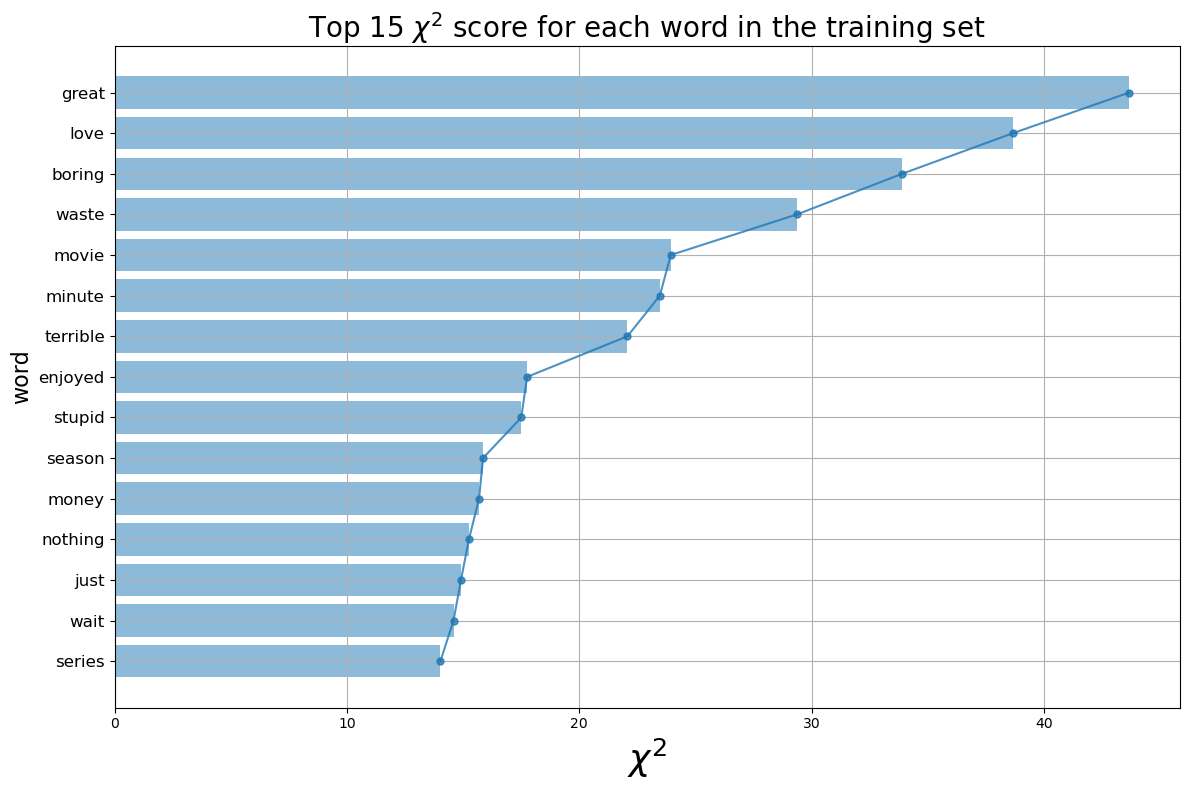

In [47]:
i = 15

chi2score = chi2(X_train_, y_train)[0]
scores = list(zip(cv.get_feature_names(), chi2score))
sorted_scores = sorted(scores, key=lambda x:x[1])
topchi2 = list(zip(*sorted_scores[-i:]))
x = range(len(topchi2[1]))
labels = topchi2[0]

plt.figure(figsize=(12, 8))
plt.barh(x,topchi2[1], align='center', alpha=0.5)
plt.plot(topchi2[1], x, '-o', markersize=5, alpha=0.8)
plt.yticks(x, labels, fontsize=12)
plt.xlabel('$\chi^2$', fontsize=26)
plt.ylabel('word', fontsize=16)
plt.title('Top {} $\chi^2$ score for each word in the training set'.format(i), fontsize=20)
plt.grid()
plt.tight_layout()
plt.show();

# Ejercicio 3 -  Etapa de entrenamiento y testeo de un modelo de análisis de sentimiento

Guardamos 20 reviews para hacer pruebas

In [ ]:
reviews = X_train[-20:]
X = X_train_[-20:]
y = y_train.iloc[-20:]

X_train = X_train_[:-20]
y_train = y_train.iloc[:-20]

## Modelo 1 Regresión Logística

In [49]:
df = pd.DataFrame(columns = ['c_params', 'train', 'test'])

for c in [0.01, 0.02, 0.03, 0.04, 0.05, 0.25, 0.5, 1, 10, 100, 1000]:
    
    lr = LogisticRegression(C = c, solver = 'lbfgs', max_iter = 500)
    lr.fit(X_train, y_train)
    
    df = df.append({'c_params' : c,
                    'train' : accuracy_score(y_train, lr.predict(X_train)),
                    'test' : accuracy_score(y_test, lr.predict(X_test_))},
                   ignore_index = True)

print(df.sort_values('test').iloc[-1])

c_params    1.000000
train       0.890525
test        0.821924
Name: 7, dtype: float64


Vemos que el mejor resultado en test se obtiene en c = 1

## Modelo 2 GradientBoostingClassifier

In [51]:
df = pd.DataFrame(columns = ['n_estimators', 'learning_rate', 'max_depth', 'train', 'test'])

for m in [1, 2]:
    for c in [50, 100, 150]:
        for l in [0.5, 1]:
            clf = GradientBoostingClassifier(n_estimators = c,
                                             learning_rate = l,
                                             max_depth = m, 
                                             random_state = 42)
            clf.fit(X_train, y_train)   
            df = df.append({'n_estimators' : c,
                            'learning_rate' : l,
                            'max_depth' : m,
                            'train' : accuracy_score(y_train, clf.predict(X_train)),
                            'test' : accuracy_score(y_test, clf.predict(X_test_))},
                           ignore_index = True)

print(df.sort_values('test').iloc[-1])

n_estimators     150.000000
learning_rate      0.500000
max_depth          2.000000
train              0.917994
test               0.778446
Name: 10, dtype: float64


Vemos que el mejor resultado en test se obtiene en n_estimators = 150, learning_rate = 0.5 y max_depth = 2

### Pruebas

In [53]:
for i in range (20):
    print(f'Review :\n"{reviews.iloc[i]}"')
    print(f"Pred lr: {lr.predict(X[i])[0]}  Pred clf2 : {clf2.predict(X[i])[0]}")
    print(f"Real : {y.iloc[i]}")
    print("------------------")

Review :
"noticed twenty-five favorite movie available streaming prime read review floored poor review must everybody's people watch clue minor spoiler theme follow offbeat told unusual adage show tell followed throughout perfectly goodness sake time spent viewing movie worth little reflection meaning absurd event muriel's life mirror absurdity life writ large movie's young woman want desperately somebody awkward weird know behave inevitably wrong thing crowd shuns still gain acceptance effort demonstrated backdrop relation dysfunctional family misfit resents amalgam parent mother insecure self loathing father grandiose liar will dishonest length seem important make news garner attention mean possible politician mother just want valued husband child avail muriel's younger sibling even pathetic actually look hapless muriel inspiration guidance movie muriel's quest find find meaning life holy grail quest though necessarily realized goal first just want live various desperate thing inspir

# 4. Reporte de métricas y conclusiones

In [58]:
clf2 = GradientBoostingClassifier(n_estimators = 150,
                                     learning_rate = 0.5,
                                     max_depth = 2, 
                                     random_state = 42)
clf2.fit(X_train, y_train)  

print(f'Confussion matrix:\n{confusion_matrix(y_test, clf2.predict(X_test_))}')
print(f'\nClassification report:\n{classification_report(y_test, clf2.predict(X_test_))}')
print(f'Accuracy score:{accuracy_score(y_test, clf2.predict(X_test_))}')

Confussion matrix:
[[825 245]
 [234 858]]

Classification report:
              precision    recall  f1-score   support

           0       0.78      0.77      0.78      1070
           1       0.78      0.79      0.78      1092

    accuracy                           0.78      2162
   macro avg       0.78      0.78      0.78      2162
weighted avg       0.78      0.78      0.78      2162

Accuracy score:0.7784458834412581


In [55]:
lr = LogisticRegression(C = 1, solver = 'lbfgs', max_iter = 500)
lr.fit(X_train, y_train)
    
print(f'Confussion matrix:\n{confusion_matrix(y_test, lr.predict(X_test_))}')
print(f'\nClassification report:\n{classification_report(y_test, lr.predict(X_test_))}')
print(f'Accuracy score:{accuracy_score(y_test, lr.predict(X_test_))}')

Confussion matrix:
[[902 168]
 [217 875]]

Classification report:
              precision    recall  f1-score   support

           0       0.81      0.84      0.82      1070
           1       0.84      0.80      0.82      1092

    accuracy                           0.82      2162
   macro avg       0.82      0.82      0.82      2162
weighted avg       0.82      0.82      0.82      2162

Accuracy score:0.8219241443108233


Vemos que en este caso el mejor modelo ha sido la regresión logística.

El equilibrio es patente, tanto en el número de muestras como en los indicadores f1-score y recall. En más del 80% de los casos que se designe un sentimiento, ya sea negativo o positivo, se acertará.
